In [ ]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import yfinance as yf
import datetime
from datetime import datetime, timedelta
import requests
import io
import os
import re
import pandas as pd
import time 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.error import HTTPError
import traceback
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
#pip install yfinance

In [3]:
#['FTNT','RMD','PAYC','WST','ASML']
news_tables = {}
tickers = ['FTNT']

In [4]:
#Reading in our articles from finviz
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
     # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table
    

In [5]:
ftnt = news_tables['FTNT']
# Get all the table rows tagged in HTML with <tr> into 'mrna_tr'
ftnt_tr = ftnt.findAll('tr')

for i, table_row in enumerate(ftnt_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

5 Stocks Leading the Rally in S&P 500 ETF
Aug-17-21 10:05AM  
Fortinet and HashiCorp Announce FortiManager Integration with Terraform to Automate and Simplify Cloud Security
09:00AM  
Q2 Earnings Fails to Impress Cybersecurity ETFs
Aug-13-21 10:40AM  
Did You Miss Fortinet's (NASDAQ:FTNT) Whopping 813% Share Price Gain?
Aug-06-21 05:38AM  


In [6]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]   
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
#parsed_news

In [7]:
#pip install vader
import nltk 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jhunt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [9]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['Symbols', 'Date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
df2 = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = df2['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
df2 = df2.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
df2['Date'] = pd.to_datetime(df2.Date).dt.date

df2.head()

,Symbols,Date,time,headline,neg,neu,pos,compound
0,FTNT,2021-08-17,10:05AM,5 Stocks Leading the Rally in S&P 500 ETF,0.000,1.000,0.000,0.0000
1,FTNT,2021-08-17,09:00AM,Fortinet and HashiCorp Announce FortiManager I...,0.000,0.844,0.156,0.3400
2,FTNT,2021-08-13,10:40AM,Q2 Earnings Fails to Impress Cybersecurity ETFs,0.262,0.467,0.271,0.0258
3,FTNT,2021-08-06,05:38AM,Did You Miss Fortinet's (NASDAQ:FTNT) Whopping...,0.113,0.493,0.394,0.6124
4,FTNT,2021-08-05,08:30AM,Here's How Much You'd Have If You Invested $10...,0.000,1.000,0.000,0.0000


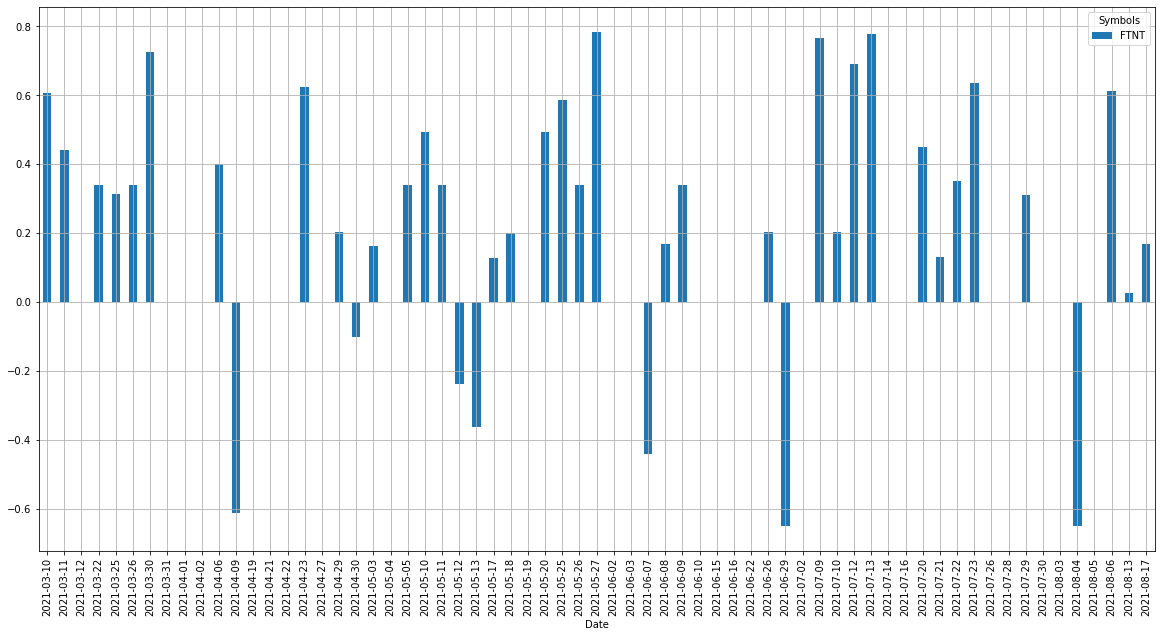

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = df2.groupby(['Symbols','Date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [11]:
#df2.reset_index(inplace=True)
df2 = df2.drop(columns=['headline','time'])
df2.head()

,Symbols,Date,neg,neu,pos,compound
0,FTNT,2021-08-17,0.000,1.000,0.000,0.0000
1,FTNT,2021-08-17,0.000,0.844,0.156,0.3400
2,FTNT,2021-08-13,0.262,0.467,0.271,0.0258
3,FTNT,2021-08-06,0.113,0.493,0.394,0.6124
4,FTNT,2021-08-05,0.000,1.000,0.000,0.0000


In [13]:
#More Cleaning
df2.index = pd.to_datetime(df2['Date'], dayfirst=True)
df2 = df2.drop(columns=['Date'])
df2.head()

,Symbols,neg,neu,pos,compound
Date,,,,,
2021-08-17,FTNT,0.000,1.000,0.000,0.0000
2021-08-17,FTNT,0.000,0.844,0.156,0.3400
2021-08-13,FTNT,0.262,0.467,0.271,0.0258
2021-08-06,FTNT,0.113,0.493,0.394,0.6124
2021-08-05,FTNT,0.000,1.000,0.000,0.0000


In [14]:
df2 = df2.groupby(['Date'], as_index=True).sum()
df2.head()

,neg,neu,pos,compound
Date,,,,
2021-03-10,0.0,1.804,1.196,1.8214
2021-03-11,0.0,1.351,0.649,0.8831
2021-03-12,0.0,1.000,0.000,0.0000
2021-03-22,0.0,0.870,0.130,0.3400
2021-03-25,0.0,1.568,0.432,0.6246


In [15]:
df2 = df2.sort_values(by=['Date'],ascending = False)
df2.head()

,neg,neu,pos,compound
Date,,,,
2021-08-17,0.000,1.844,0.156,0.3400
2021-08-13,0.262,0.467,0.271,0.0258
2021-08-06,0.113,0.493,0.394,0.6124
2021-08-05,0.000,1.000,0.000,0.0000
2021-08-04,0.371,0.629,0.000,-0.6486


In [16]:
#pip install pandas_datareader
from pandas_datareader import data as pdr 

In [17]:
#Pulling in data from YFinance
start = '2020-8-17'
end = '2021-8-17'
symbols = ['FTNT']

In [18]:
data = pdr.get_data_yahoo(symbols, start, end)

In [19]:
df = pd.DataFrame(data)
df.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,FTNT,FTNT,FTNT,FTNT,FTNT,FTNT
Date,,,,,,
2020-08-17,129.160004,129.160004,130.460007,128.500000,128.500000,883200
2020-08-18,129.919998,129.919998,131.369995,128.210007,130.100006,868700
2020-08-19,129.509995,129.509995,130.759995,127.599998,129.250000,1335900
2020-08-20,133.589996,133.589996,133.940002,128.750000,130.429993,922200
2020-08-21,131.710007,131.710007,134.309998,130.919998,133.830002,800700


In [20]:
#More DF Shaping 
df=df.stack()

df = df.sort_values(by=['Symbols','Date','Close','High','Low','Open','Volume'],ascending = False)

df.head()


,Attributes,Adj Close,Close,High,Low,Open,Volume
Date,Symbols,,,,,,
2021-08-17,FTNT,298.630005,298.630005,302.269989,295.190002,300.140015,895500
2021-08-16,FTNT,302.440002,302.440002,309.000000,298.670013,309.000000,757800
2021-08-13,FTNT,309.329987,309.329987,309.529999,302.209991,303.500000,598300
2021-08-12,FTNT,305.660004,305.660004,309.790009,298.279999,299.339996,1156100
2021-08-11,FTNT,298.670013,298.670013,302.980011,293.709991,301.429993,979500


In [21]:
#Creating upside column used to pass into model later 
df['daily_return'] = df['Close'].pct_change()
df['upside'] = np.where(df['daily_return'] > 0, 1.0, 0.0)

df.head()

,Attributes,Adj Close,Close,High,Low,Open,Volume,daily_return,upside
Date,Symbols,,,,,,,,
2021-08-17,FTNT,298.630005,298.630005,302.269989,295.190002,300.140015,895500,NaN,0.0
2021-08-16,FTNT,302.440002,302.440002,309.000000,298.670013,309.000000,757800,0.012758,1.0
2021-08-13,FTNT,309.329987,309.329987,309.529999,302.209991,303.500000,598300,0.022781,1.0
2021-08-12,FTNT,305.660004,305.660004,309.790009,298.279999,299.339996,1156100,-0.011864,0.0
2021-08-11,FTNT,298.670013,298.670013,302.980011,293.709991,301.429993,979500,-0.022869,0.0
2021-08-10,FTNT,300.399994,300.399994,304.359985,298.119995,301.529999,722200,0.005792,1.0
2021-08-09,FTNT,301.109985,301.109985,305.500000,299.190002,305.149994,724900,0.002363,1.0
2021-08-06,FTNT,303.679993,303.679993,303.769989,296.000000,298.549988,795800,0.008535,1.0
2021-08-05,FTNT,300.019989,300.019989,306.510010,298.269989,305.000000,1324200,-0.012052,0.0


In [22]:
#df = df.loc[~df.index.duplicated(keep='first')]

In [23]:
#df2 = df2.loc[~df2.index.duplicated(keep='first')]

In [24]:
#Merging of price data and sentiment  data 
df3 = pd.merge(df, df2, how='outer', on = 'Date')
df3 = df3.fillna(0)
df3.head(10)


,Adj Close,Close,High,Low,Open,Volume,daily_return,upside,neg,neu,pos,compound
Date,,,,,,,,,,,,
2021-08-17,298.630005,298.630005,302.269989,295.190002,300.140015,895500.0,0.000000,0.0,0.000,1.844,0.156,0.3400
2021-08-16,302.440002,302.440002,309.000000,298.670013,309.000000,757800.0,0.012758,1.0,0.000,0.000,0.000,0.0000
2021-08-13,309.329987,309.329987,309.529999,302.209991,303.500000,598300.0,0.022781,1.0,0.262,0.467,0.271,0.0258
2021-08-12,305.660004,305.660004,309.790009,298.279999,299.339996,1156100.0,-0.011864,0.0,0.000,0.000,0.000,0.0000
2021-08-11,298.670013,298.670013,302.980011,293.709991,301.429993,979500.0,-0.022869,0.0,0.000,0.000,0.000,0.0000
2021-08-10,300.399994,300.399994,304.359985,298.119995,301.529999,722200.0,0.005792,1.0,0.000,0.000,0.000,0.0000
2021-08-09,301.109985,301.109985,305.500000,299.190002,305.149994,724900.0,0.002363,1.0,0.000,0.000,0.000,0.0000
2021-08-06,303.679993,303.679993,303.769989,296.000000,298.549988,795800.0,0.008535,1.0,0.113,0.493,0.394,0.6124
2021-08-05,300.019989,300.019989,306.510010,298.269989,305.000000,1324200.0,-0.012052,0.0,0.000,1.000,0.000,0.0000


In [25]:
#Data Frame well be using for predictive model
keep_columns =['upside', 'compound','pos','neg','neu']
df4= df3[keep_columns]
df4.head(10)

,upside,compound,pos,neg,neu
Date,,,,,
2021-08-17,0.0,0.3400,0.156,0.000,1.844
2021-08-16,1.0,0.0000,0.000,0.000,0.000
2021-08-13,1.0,0.0258,0.271,0.262,0.467
2021-08-12,0.0,0.0000,0.000,0.000,0.000
2021-08-11,0.0,0.0000,0.000,0.000,0.000
2021-08-10,1.0,0.0000,0.000,0.000,0.000
2021-08-09,1.0,0.0000,0.000,0.000,0.000
2021-08-06,1.0,0.6124,0.394,0.113,0.493
2021-08-05,0.0,0.0000,0.000,0.000,1.000


In [26]:
X = df4
X=np.array(X.drop(['upside'], 1))
y = np.array(df4['upside'])           

In [27]:
#Split the data into 80% training and 20% testing data set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [28]:
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [29]:
#Show the models prediction 
predictions = model.predict(x_test)
predictions 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0.])

In [30]:
y_test

array([0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1.])

In [31]:
#Show the model metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.57      0.93      0.71        30
         1.0       0.33      0.05      0.08        22

    accuracy                           0.56        52
   macro avg       0.45      0.49      0.39        52
weighted avg       0.47      0.56      0.44        52

